<a href="https://colab.research.google.com/github/shreekanthsenthil/plant-seedling-detection/blob/main/Plant_Seedling_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors
import random
import cv2
import pickle

from math import sqrt, floor

import tensorflow as tf
import datetime

%load_ext tensorboard


# **ANALYSIS**

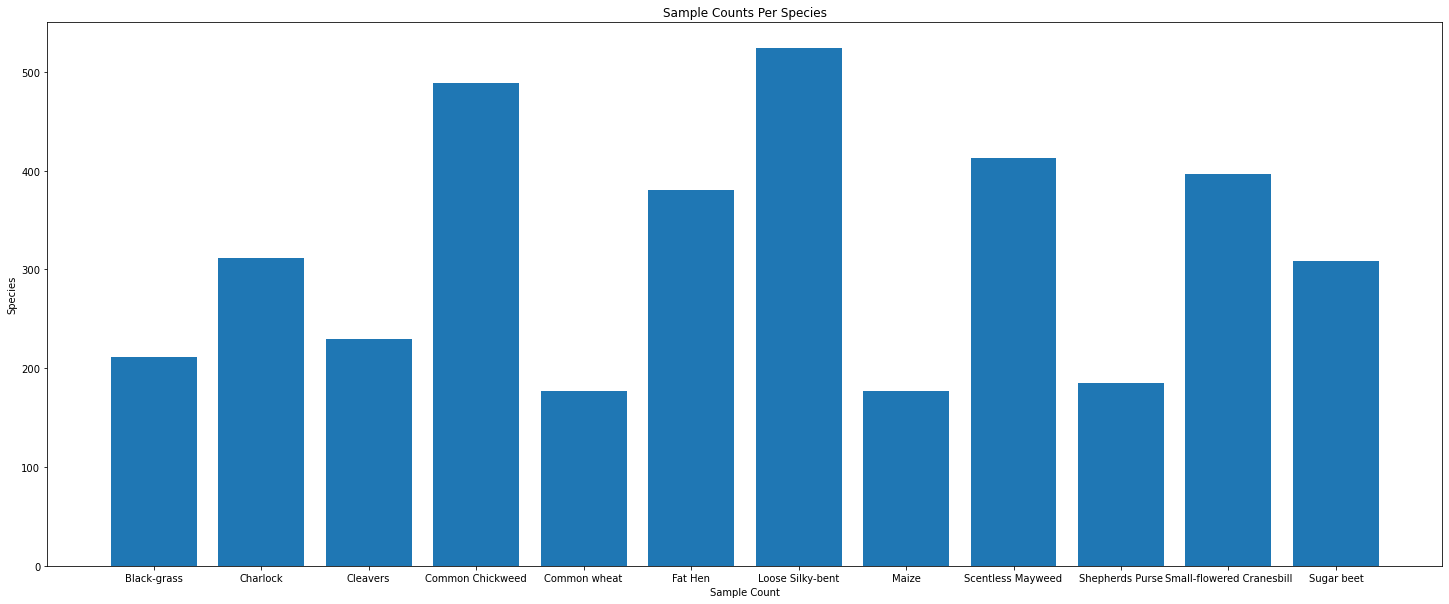

Black-grass :  211
Charlock :  312
Cleavers :  230
Common Chickweed :  489
Common wheat :  177
Fat Hen :  380
Loose Silky-bent :  524
Maize :  177
Scentless Mayweed :  413
Shepherds Purse :  185
Small-flowered Cranesbill :  397
Sugar beet :  308


In [ ]:
classes = [
           'Black-grass',
           'Charlock',
           'Cleavers',
           'Common Chickweed',
           'Common wheat',
           'Fat Hen',
           'Loose Silky-bent',
           'Maize',
           'Scentless Mayweed',
           'Shepherds Purse',
           'Small-flowered Cranesbill',
           'Sugar beet'
           ]

sample_counts = []

for className in classes:
  if os.path.isdir(os.path.join('./Dataset/train', className)):
    sample_counts.append(len(os.listdir(os.path.join('./Dataset/train', className))))
  else:
    print(className)

plt.figure(figsize=(25,10))
plt.bar(classes, sample_counts)
plt.title('Sample Counts Per Species')
plt.ylabel('Species')
plt.xlabel('Sample Count')
plt.show()

for i in range(len(classes)):
  print(classes[i] + " : " , sample_counts[i])


 Black-grass


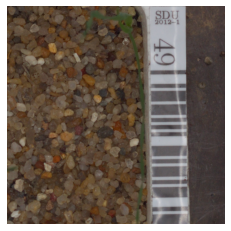


 Charlock


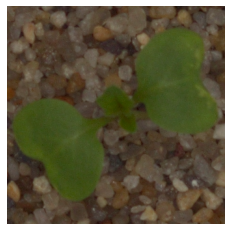


 Cleavers


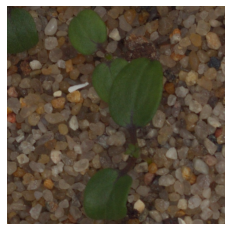


 Common Chickweed


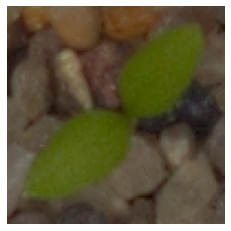


 Common wheat


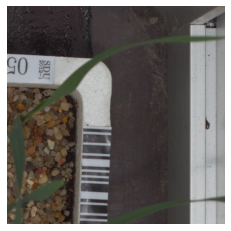


 Fat Hen


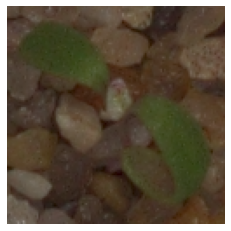


 Loose Silky-bent


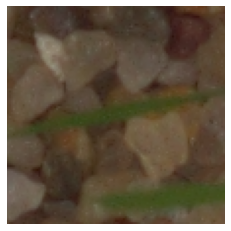


 Maize


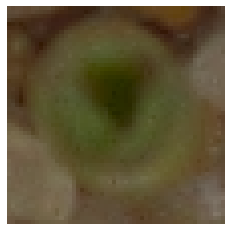


 Scentless Mayweed


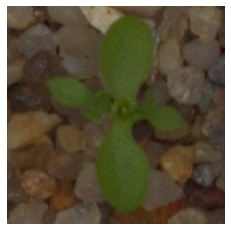


 Shepherds Purse


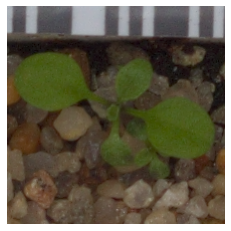


 Small-flowered Cranesbill


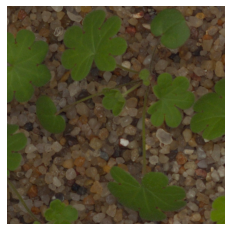


 Sugar beet


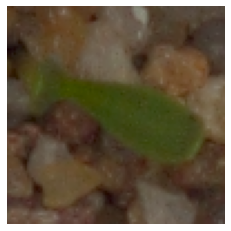

In [ ]:
for i in range(12):
  sample_path = os.path.join('./Dataset/train', classes[i])
  random_image_path = os.path.join(sample_path, random.choice(os.listdir(sample_path)))
  print("\n", classes[i])
  random_image = cv2.imread(random_image_path)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
  plt.show()


# **PRE-PROCESSING**

In [ ]:
for i in range(12):
  sample_path = os.path.join('/content/drive/MyDrive/SE Project/Dataset/train', classes[i])
  random_image_path = os.path.join(sample_path, random.choice(os.listdir(sample_path)))
  print("\n", classes[i])
  random_image = cv2.imread(random_image_path)
  print(random_image.shape)


 Black-grass
(614, 615, 3)

 Charlock
(311, 311, 3)

 Cleavers
(540, 540, 3)

 Common Chickweed
(106, 106, 3)

 Common wheat
(745, 745, 3)

 Fat Hen
(336, 336, 3)

 Loose Silky-bent
(211, 211, 3)

 Maize
(866, 866, 3)

 Scentless Mayweed
(126, 126, 3)

 Shepherds Purse
(119, 119, 3)

 Small-flowered Cranesbill
(748, 748, 3)

 Sugar beet
(1036, 1036, 3)


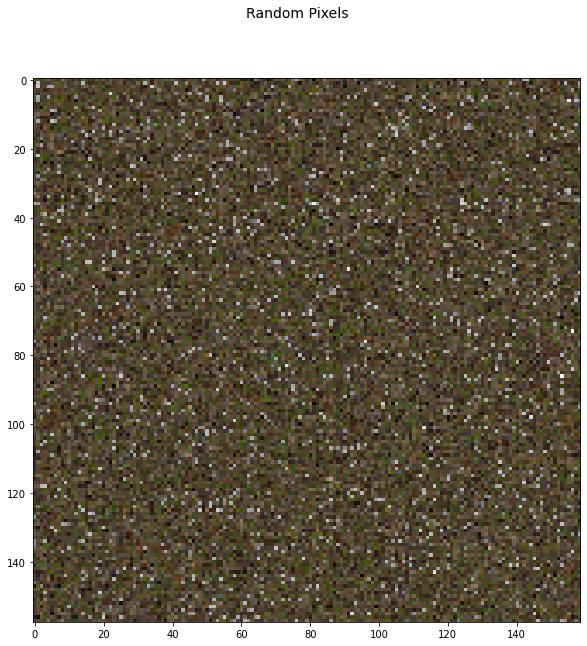

In [ ]:
def generate_random_pixel_image(samples_per_class, pixels_per_image):
  total_pixels = 12*samples_per_class * pixels_per_image
  random_pixels = np.zeros((total_pixels, 3), dtype=np.uint8)
  for i in range(12):
    sample_class = os.path.join('/content/drive/MyDrive/SE Project/Dataset/train', classes[i])
    for j in range(samples_per_class):
      random_image = os.path.join(sample_class, random.choice(os.listdir(sample_class)))
      image = cv2.imread(random_image)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = np.reshape(image, (image.shape[0]*image.shape[1] , 3))
      new_pixels = image[np.random.randint(0, image.shape[0], pixels_per_image)]
      start_index = pixels_per_image * (i * samples_per_class + j)
      random_pixels[start_index: start_index+pixels_per_image, :] = new_pixels

  h = floor(sqrt(total_pixels))
  w = total_pixels//h

  random_pixels = random_pixels[np.random.choice(total_pixels, h*w, replace=False)]
  random_pixels = np.reshape(random_pixels, (h, w, 3))
  return random_pixels
      


random_pixels = generate_random_pixel_image(30,70)

plt.figure(figsize=(10,10))
plt.suptitle('Random Pixels', fontsize=14, horizontalalignment='center')
plt.imshow(random_pixels)
plt.show()

Plot Random Pixels in RGB Space

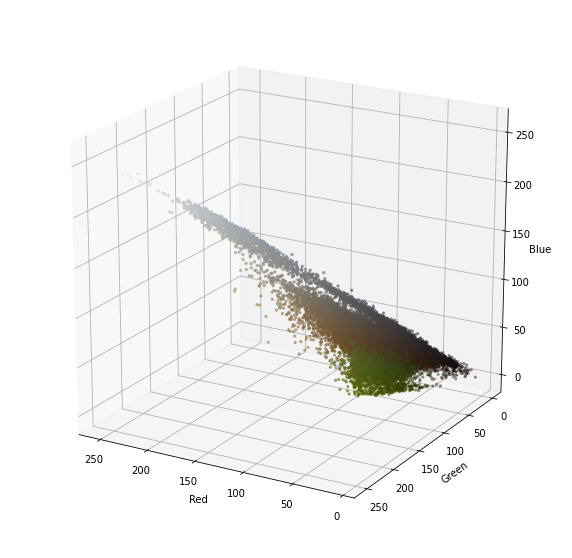

In [ ]:

r, g, b = cv2.split(random_pixels)
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.view_init(20, 120)

pixel_colors = random_pixels.reshape((np.shape(random_pixels)[0]*np.shape(random_pixels)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()


axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

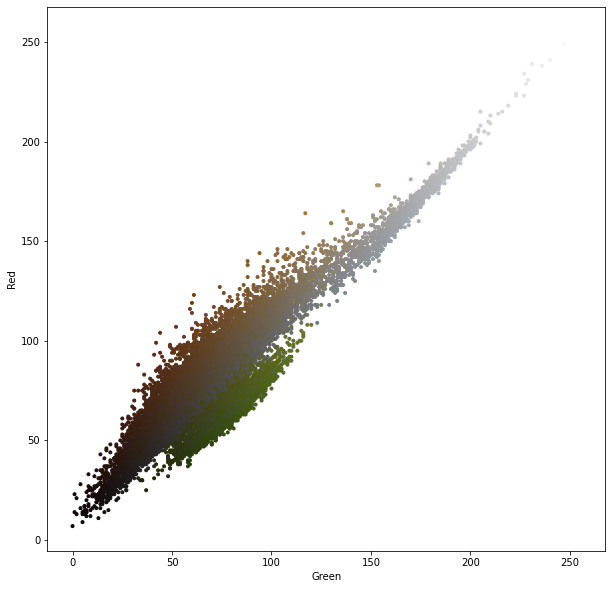

In [ ]:
r, g, b = cv2.split(random_pixels)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1)

axis.scatter(g.flatten(), r.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Green")
axis.set_ylabel("Red")
plt.show()

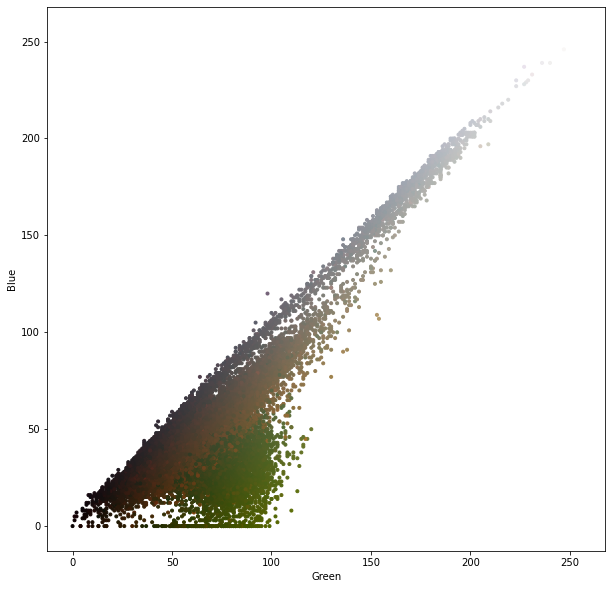

In [ ]:
r, g, b = cv2.split(random_pixels)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1)

axis.scatter(g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Green")
axis.set_ylabel("Blue")
plt.show()

Plot Random Pixels in HSV Space

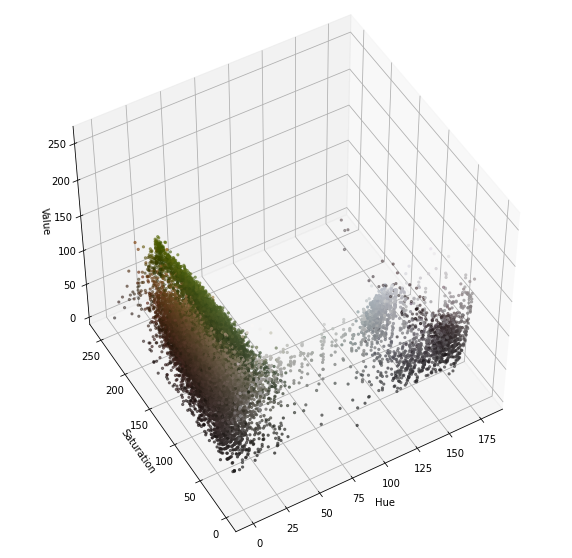

In [ ]:
hsv_image = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_image)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1,1,1, projection="3d")
axis.view_init(50,240)

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

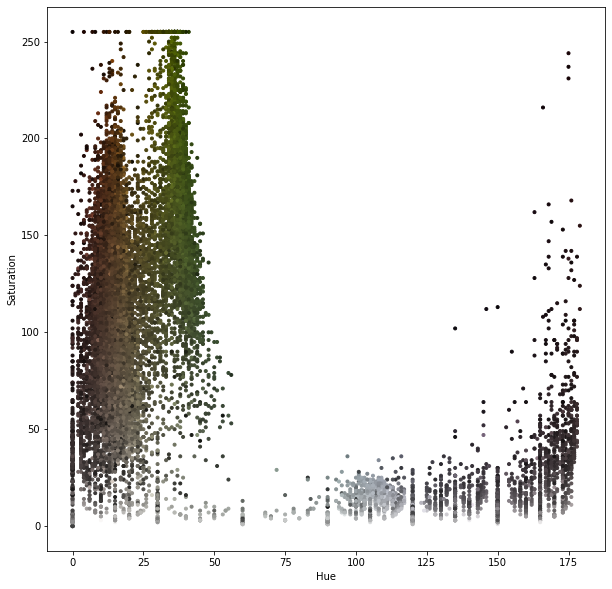

In [ ]:
hsv_img = cv2.cvtColor(np.uint8(random_pixels), cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_img)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1)

axis.scatter(h.flatten(), s.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
plt.show()

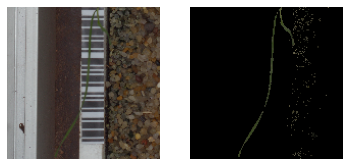

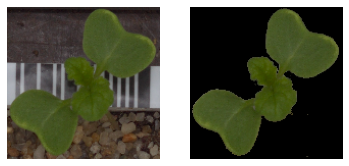

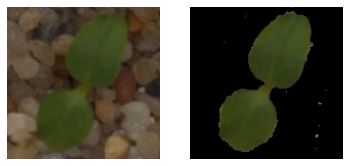

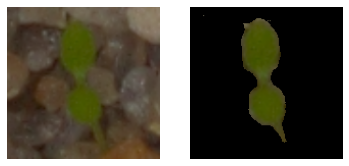

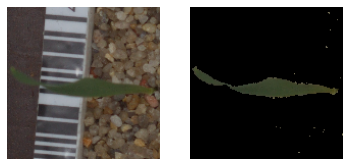

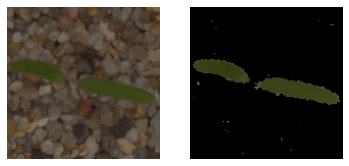

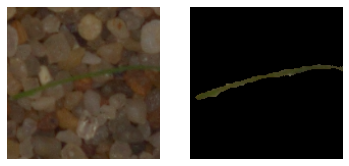

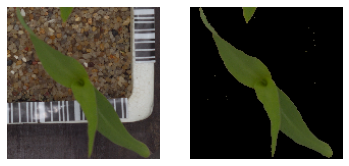

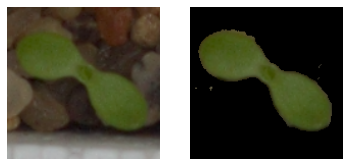

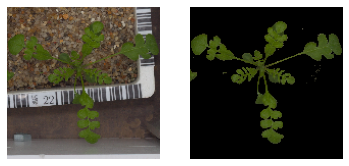

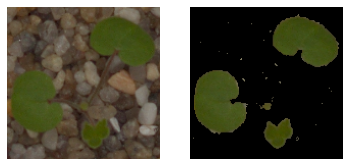

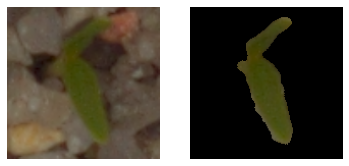

In [ ]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

for i in range(12):
    sample_class=os.path.join('./Dataset/train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, lower_bound, upper_bound)
    result = cv2.bitwise_and(img, img, mask=mask)

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()

    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.axis('off')
    plt.show()
    
# plt.show()

In [ ]:
def pre_processing_function(image): 
  image = np.rint(image)
  image = image.astype('uint8')
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  mask = cv2.inRange(hsv_image, (24, 50, 0), (55, 255, 255))
  result = cv2.bitwise_and(image, image, mask=mask)
  # result = result.astype('float64')
  return result

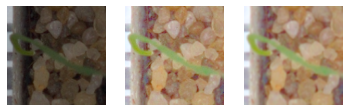

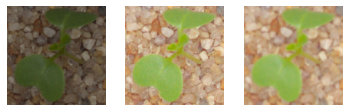

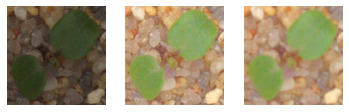

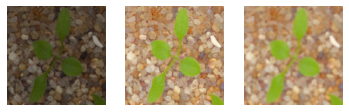

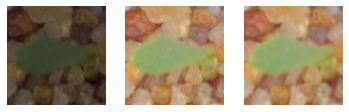

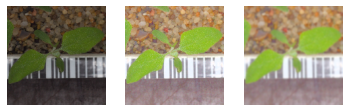

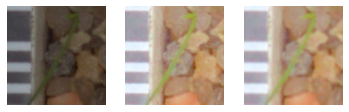

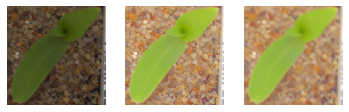

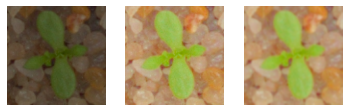

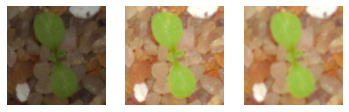

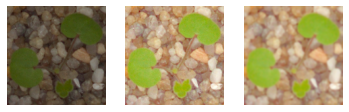

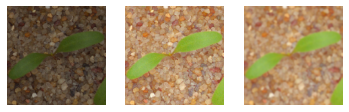

In [ ]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

for i in range(12):
    sample_class=os.path.join('./Dataset/train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    value = 100
    
    hsv_img= cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    brighten = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    result = cv2.GaussianBlur(brighten, (5,5), 0)

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()

    plt.subplot(1,3,2)
    plt.imshow(brighten)
    plt.axis('off')
    # plt.show()
    
    plt.subplot(1,3,3)
    plt.imshow(result)
    plt.axis('off')
    plt.show()
    

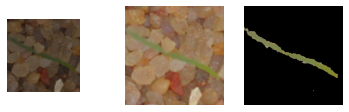

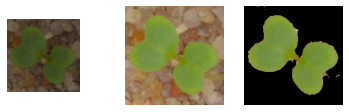

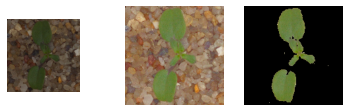

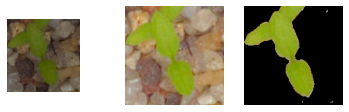

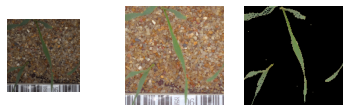

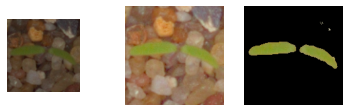

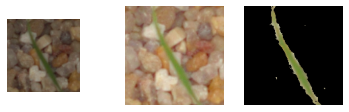

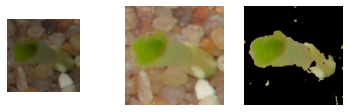

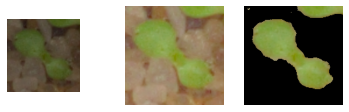

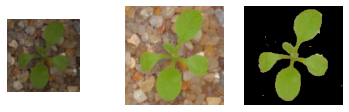

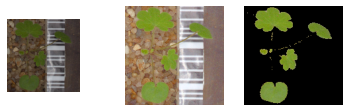

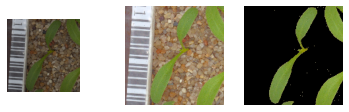

In [ ]:
lower_bound= (24, 50, 0)
upper_bound= (55, 255, 255)

for i in range(12):
    sample_class=os.path.join('./Dataset/train',classes[i])
    random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
    img= cv2.imread(random_image)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, (150, 150))
    value = 70
    
    hsv_image_bg_remove = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_bg_remove = cv2.inRange(hsv_image_bg_remove, (24, 50, 0), (55, 255, 255))
    result_bg_remove = cv2.bitwise_and(img, img, mask=mask_bg_remove)
    
    hsv_img_brigthen = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img_brigthen)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv_brigthen = cv2.merge((h, s, v))
    result_brighten = cv2.cvtColor(final_hsv_brigthen, cv2.COLOR_HSV2RGB)
    result_brigthen = cv2.GaussianBlur(result_brighten, (5,5), 0)

    hsv_image_final = cv2.cvtColor(result_brighten, cv2.COLOR_RGB2HSV)
    mask_final = cv2.inRange(hsv_image_final, (24, 50, 0), (55, 255, 255))
    result_final = cv2.bitwise_and(result_brighten, result_brighten, mask=mask_final)

    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.axis('off')
    # plt.show()

    # plt.subplot(1,4,2)
    # plt.imshow(result_bg_remove)
    # plt.axis('off')
    # plt.show()
    
    plt.subplot(1,3,2)
    plt.imshow(result_brighten)
    plt.axis('off')
    # plt.show()

    plt.subplot(1,3,3)
    plt.imshow(result_final)
    plt.axis('off')
    plt.show()
    

In [ ]:
def pre_processing_remove_bg(img_array):
    img_array = np.rint(img_array)
    img_array = img_array.astype('uint8')
    hsv_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, (24, 50, 0), (55, 255, 255))
    result = cv2.bitwise_and(img_array, img_array, mask=mask)
    result = result.astype('float64')
    return result

In [ ]:
def pre_processing_brighten(img_array):
    img_array= np.rint(img_array)
    img_array= img_array.astype('uint8')
    hsv_img= cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    value = 40
    hsv_img_brigthen = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img_brigthen)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv_brigthen = cv2.merge((h, s, v))
    result_brighten = cv2.cvtColor(final_hsv_brigthen, cv2.COLOR_HSV2RGB)
    result_brigthen = cv2.GaussianBlur(result_brighten, (5,5), 0)

    result= result_brighten.astype('float64')
    return result

In [2]:
def pre_processing_combined(img_array):
    img_array = np.rint(img_array)
    img_array = img_array.astype('uint8')

    value = 40
    hsv_img_brigthen = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_img_brigthen)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv_brigthen = cv2.merge((h, s, v))
    result_brighten = cv2.cvtColor(final_hsv_brigthen, cv2.COLOR_HSV2RGB)
    result_brighten = cv2.GaussianBlur(result_brighten, (5,5), 0)

    hsv_img = cv2.cvtColor(result_brighten, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_img, (24, 50, 0), (55, 255, 255))
    result = cv2.bitwise_and(result_brighten, result_brighten, mask=mask)
    result= result.astype('float64')
    return result

[[[120  94  79]
  [126 103  90]
  [125 106  89]
  ...
  [162 145 119]
  [161 142 117]
  [154 131 105]]

 [[124 101  88]
  [124 105  88]
  [126 108  90]
  ...
  [163 148 121]
  [163 144 120]
  [160 137 114]]

 [[127 108  93]
  [127 109  93]
  [121 102  84]
  ...
  [168 152 125]
  [162 145 117]
  [155 132 105]]

 ...

 [[109  82  59]
  [121  94  71]
  [121  92  67]
  ...
  [105  79  68]
  [106  79  66]
  [105  75  65]]

 [[106  80  54]
  [117  92  68]
  [122  96  68]
  ...
  [105  81  70]
  [107  82  69]
  [104  77  63]]

 [[113  89  65]
  [122  99  74]
  [126 103  74]
  ...
  [ 96  71  58]
  [103  79  67]
  [105  78  65]]]


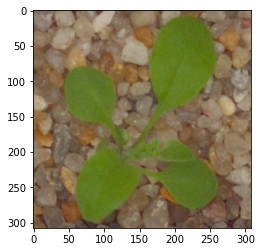

In [ ]:
img = cv2.imread("./Dataset/train/Shepherds Purse/00dd0d16a.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = pre_processing_brighten(img)
img = img.astype('uint8')
print(img)
plt.imshow(img)
plt.show()

# **Creating Validation Set**

In [ ]:
def create_validation(split = 0.2):
  if os.path.isdir('./Dataset/validation'):
    print("Validation Set Already Exist")
    return
  os.mkdir('./Dataset/validation')
  for f in os.listdir('./Dataset/train'):
    train_class = os.path.join('./Dataset/train', f)
    if os.path.isdir(train_class):
      validation_class = os.path.join('./Dataset/validation', f)
      os.mkdir(validation_class)
      img_move = int(split * len(os.listdir(train_class)))
      for i in range(img_move):
        image = os.path.join(train_class, random.choice(os.listdir(train_class)))
        shutil.move(image, validation_class)
  print('Validation Set Created')

In [ ]:
create_validation()

Validation Set Created


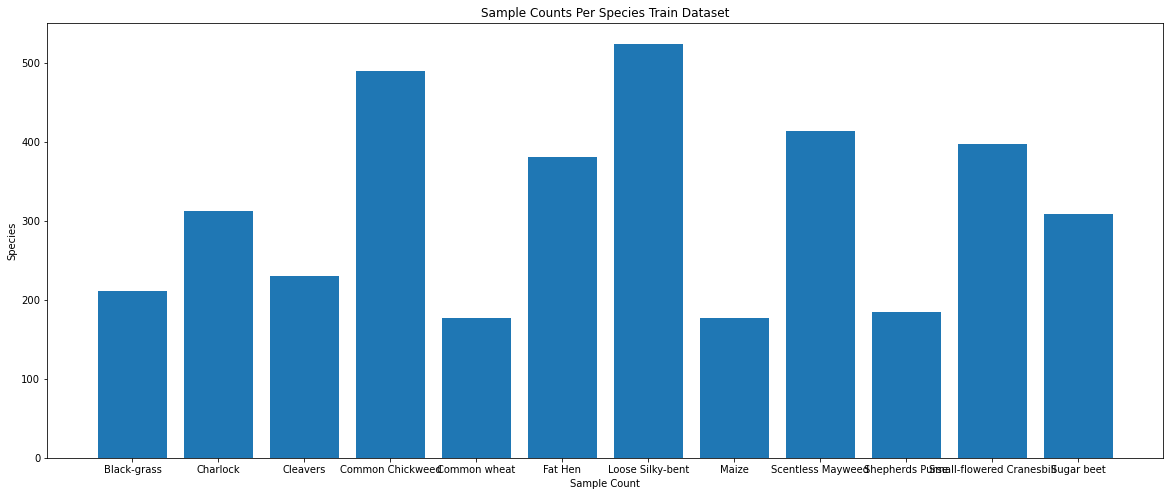

4750


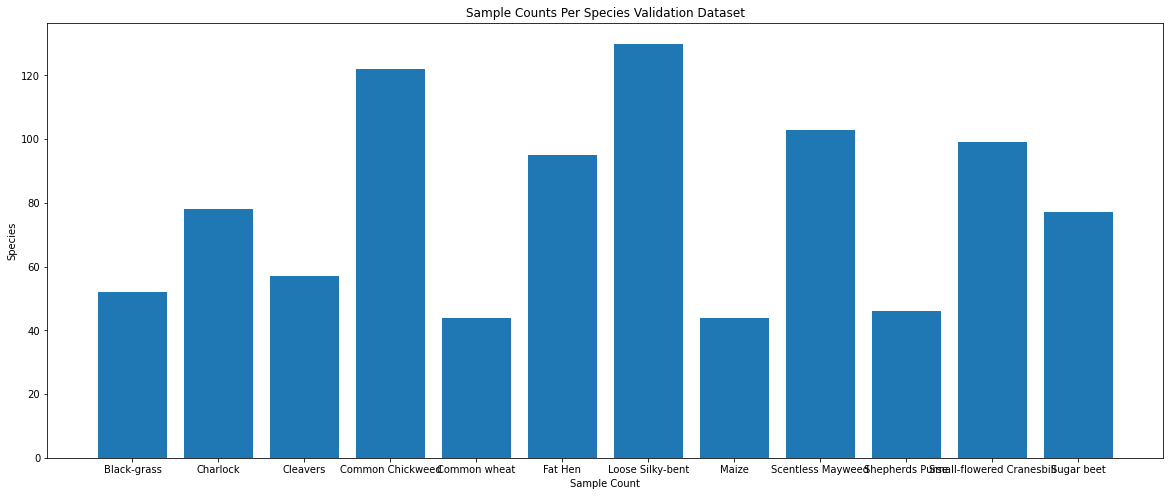

4750


In [ ]:
classes = [
           'Black-grass',
           'Charlock',
           'Cleavers',
           'Common Chickweed',
           'Common wheat',
           'Fat Hen',
           'Loose Silky-bent',
           'Maize',
           'Scentless Mayweed',
           'Shepherds Purse',
           'Small-flowered Cranesbill',
           'Sugar beet'
           ]

sample_counts = []
count = 0

for className in classes:
  if os.path.isdir(os.path.join('./Dataset/train', className)):
    sample_counts.append(len(os.listdir(os.path.join('./Dataset/train', className))))
    count += len(os.listdir(os.path.join('./Dataset/train', className)))
  else:
    print(className)

plt.figure(figsize=(20,8))
plt.bar(classes, sample_counts)
plt.title('Sample Counts Per Species Train Dataset')
plt.ylabel('Species')
plt.xlabel('Sample Count')
plt.show()

sample_counts = []

for className in classes:
  if os.path.isdir(os.path.join('./Dataset/validation', className)):
    sample_counts.append(len(os.listdir(os.path.join('./Dataset/validation', className))))
    count += len(os.listdir(os.path.join('./Dataset/validation', className)))
  else:
    print(className)


print(count)
plt.figure(figsize=(20,8))
plt.bar(classes, sample_counts)
plt.title('Sample Counts Per Species Validation Dataset')
plt.ylabel('Species')
plt.xlabel('Sample Count')
plt.show()

print(count)

# **Data Generation**

In [ ]:
# Uses Data Augumentation to prepare the model

train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip= True,
    preprocessing_function = pre_processing_function,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=pre_processing_function)

In [ ]:
def train_data_generator(pre_processing_function):
  return tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40,
      width_shift_range=0.0,
      height_shift_range=0.0,
      shear_range=0.0,
      zoom_range=0.0,
      horizontal_flip=True,
      vertical_flip= True,
      preprocessing_function = pre_processing_function,
      fill_mode='nearest'
  )

def test_data_generator(pre_processing_function):
  return tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=pre_processing_function)

In [ ]:
train_generator_remove_bg = train_data_generator(pre_processing_remove_bg).flow_from_directory(
  './Dataset/train',
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator_remove_bg = test_data_generator(pre_processing_remove_bg).flow_from_directory(
        './Dataset/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')


train_generator_brighten = train_data_generator(pre_processing_brighten).flow_from_directory(
  './Dataset/train',
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator_brighten = train_data_generator(pre_processing_brighten).flow_from_directory(
        './Dataset/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

train_generator_combined = train_data_generator(pre_processing_combined).flow_from_directory(
  './Dataset/train',
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator_combined = train_data_generator(pre_processing_combined).flow_from_directory(
        './Dataset/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


# **MODEL**

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))


model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))



model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))


model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Dropout(0.1))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [ ]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  # flatten output of conv
  model.add(tf.keras.layers.Flatten())
  # hidden layer
  model.add(tf.keras.layers.Dense(100, activation='relu'))
  # output layer
  model.add(tf.keras.layers.Dense(12, activation='softmax'))

  return model

In [ ]:
model_remove_bg = create_model()
model_brighten = create_model()
model_combined = create_model()

In [ ]:
model_combined.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 175232)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               17523300  
_________________________________________________________________
dense_13 (Dense)             (None, 12)                1212      
Total params: 17,525,408
Trainable params: 17,525,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def create_model_saver(path):
  model_saver_callback = tf.keras.callbacks.ModelCheckpoint(path, 
                                          monitor='val_loss', 
                                          verbose=1, 
                                          save_best_only=True, 
                                          save_weights_only=False, 
                                          mode='auto', 
                                          save_freq='epoch')
  return model_saver_callback

opt= tf.keras.optimizers.Adam(lr=0.0005, amsgrad=True)

In [ ]:
model_remove_bg_saver_callback = create_model_saver("./model_remove_bg.h5")
model_brighten_saver_callback = create_model_saver("./model_brighten.h5")
model_combined_saver_callback = create_model_saver("./model_combined.h5")

In [ ]:
# SAMPLE

model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
                    train_generator,
                    class_weight= class_weight,
                    steps_per_epoch= 190,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps= 48,
                    verbose=1,
                    callbacks= [best_cb, tensorboard_callback])

In [ ]:
model_remove_bg.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

log_dir = "./logs/fit/model_remove_bg"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_remove_bg = model_remove_bg.fit(
                    train_generator_remove_bg,
                    steps_per_epoch= 150,
                    epochs=15,
                    validation_data=validation_generator_remove_bg,
                    validation_steps= 45,
                    verbose=1,
                    callbacks= [model_remove_bg_saver_callback, tensorboard_callback])

Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.4397
Epoch 00001: val_loss improved from inf to 1.38609, saving model to ./model_remove_bg.h5
150/150 [==============================] - 166s 1s/step - loss: 1.6766 - accuracy: 0.4397 - val_loss: 1.3861 - val_accuracy: 0.5400
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 1.1056 - accuracy: 0.6286
Epoch 00002: val_loss improved from 1.38609 to 1.01129, saving model to ./model_remove_bg.h5
150/150 [==============================] - 113s 755ms/step - loss: 1.1056 - accuracy: 0.6286 - val_loss: 1.0113 - val_accuracy: 0.6370
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.6822
Epoch 00003: val_loss improved from 1.01129 to 0.90757, saving model to ./model_remove_bg.h5
150/150 [==============================] - 154s 1s/step - loss: 0.9172 - accuracy: 0.6822 - val_loss: 0.9076 - val_accuracy: 0.7057
Epoch 4/15
150/150 [==================

In [ ]:
with open('./model_history_remove_bg.pkl', 'wb') as f:
    pickle.dump(history_remove_bg.history, f)

In [ ]:
model_brighten.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

log_dir = "./logs/fit/model_brighten"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_brighten = model_brighten.fit(
                    train_generator_brighten,
                    steps_per_epoch= 150,
                    epochs=15,
                    validation_data=validation_generator_brighten,
                    validation_steps= 45,
                    verbose=1,
                    callbacks= [model_brighten_saver_callback, tensorboard_callback])

Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 2.3966 - accuracy: 0.2467
Epoch 00001: val_loss improved from inf to 1.95811, saving model to ./model_brighten.h5
150/150 [==============================] - 154s 1s/step - loss: 2.3966 - accuracy: 0.2467 - val_loss: 1.9581 - val_accuracy: 0.3122
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 1.8076 - accuracy: 0.3902
Epoch 00002: val_loss improved from 1.95811 to 1.64837, saving model to ./model_brighten.h5
150/150 [==============================] - 153s 1s/step - loss: 1.8076 - accuracy: 0.3902 - val_loss: 1.6484 - val_accuracy: 0.4532
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 1.5910 - accuracy: 0.4606
Epoch 00003: val_loss improved from 1.64837 to 1.47897, saving model to ./model_brighten.h5
150/150 [==============================] - 153s 1s/step - loss: 1.5910 - accuracy: 0.4606 - val_loss: 1.4790 - val_accuracy: 0.4938
Epoch 4/15
150/150 [========================

In [ ]:
with open('model_history_brighten.pkl', 'wb') as f:
    pickle.dump(history_brighten.history, f)

In [ ]:
model_combined.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

log_dir = "./logs/fit/model_combined"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_combined = model_combined.fit(
                    train_generator_combined,
                    steps_per_epoch= 150,
                    epochs=15,
                    validation_data=validation_generator_combined,
                    validation_steps= 45,
                    verbose=1,
                    callbacks= [model_combined_saver_callback, tensorboard_callback])

Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 2.3170 - accuracy: 0.2670
Epoch 00001: val_loss improved from inf to 1.53857, saving model to ./model_combined.h5
150/150 [==============================] - 119s 796ms/step - loss: 2.3170 - accuracy: 0.2670 - val_loss: 1.5386 - val_accuracy: 0.4822
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 1.3217 - accuracy: 0.5491
Epoch 00002: val_loss improved from 1.53857 to 1.11924, saving model to ./model_combined.h5
150/150 [==============================] - 145s 966ms/step - loss: 1.3217 - accuracy: 0.5491 - val_loss: 1.1192 - val_accuracy: 0.6313
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 1.0723 - accuracy: 0.6369
Epoch 00003: val_loss improved from 1.11924 to 0.98982, saving model to ./model_combined.h5
150/150 [==============================] - 134s 892ms/step - loss: 1.0723 - accuracy: 0.6369 - val_loss: 0.9898 - val_accuracy: 0.6640
Epoch 4/15
150/150 [===============

In [ ]:
with open('model_history_combined.pkl', 'wb') as f:
    pickle.dump(history_combined.history, f)

In [ ]:
pickle_in = open("./model_history_remove_bg.pkl","rb")
history_remove_bg = pickle.load(pickle_in)

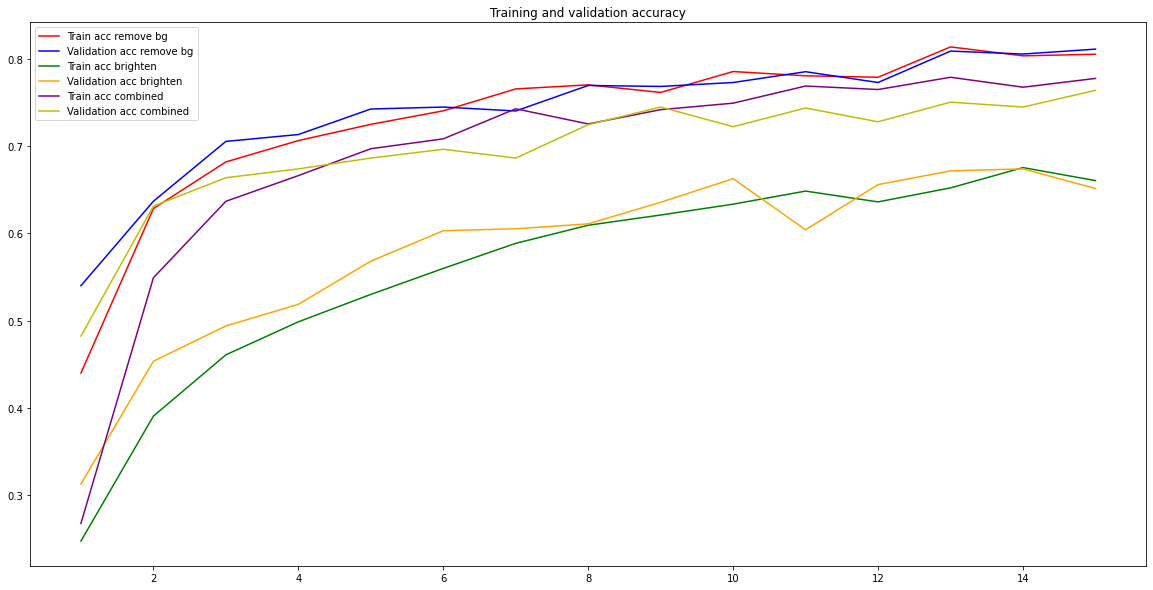

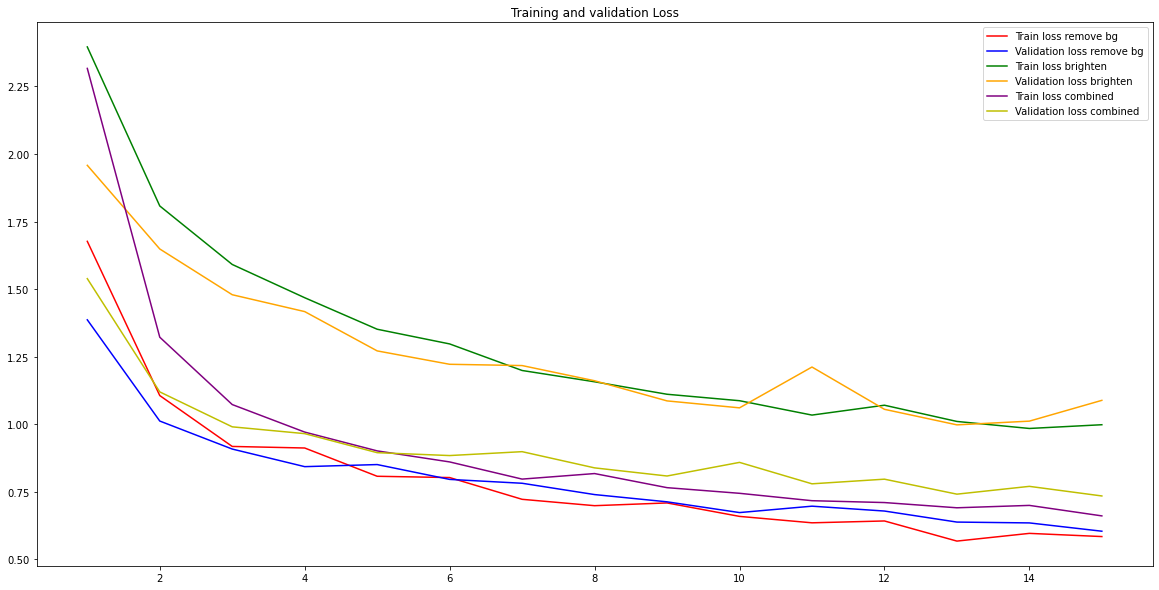

In [ ]:
acc_remove_bg = history_remove_bg['accuracy']
val_acc_remove_bg = history_remove_bg['val_accuracy']
acc_brighten = history_brighten.history['accuracy']
val_acc_brighten = history_brighten.history['val_accuracy']
acc_combined = history_combined.history['accuracy']
val_acc_combined = history_combined.history['val_accuracy']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,10))
plt.plot(epochs, acc_remove_bg, 'red', label='Train acc remove bg')
plt.plot(epochs, val_acc_remove_bg, 'b', label='Validation acc remove bg')
plt.plot(epochs, acc_brighten, 'g', label='Train acc brighten')
plt.plot(epochs, val_acc_brighten, 'orange', label='Validation acc brighten')
plt.plot(epochs, acc_combined, 'purple', label='Train acc combined')
plt.plot(epochs, val_acc_combined, 'y', label='Validation acc combined')
plt.title('Training and validation accuracy')
plt.legend()


loss_remove_bg = history_remove_bg['loss']
val_loss_remove_bg = history_remove_bg['val_loss']
loss_brighten = history_brighten.history['loss']
val_loss_brighten = history_brighten.history['val_loss']
loss_combined = history_combined.history['loss']
val_loss_combined = history_combined.history['val_loss']

plt.figure(figsize=(20,10))
plt.plot(epochs, loss_remove_bg, 'red', label='Train loss remove bg')
plt.plot(epochs, val_loss_remove_bg, 'b', label='Validation loss remove bg')
plt.plot(epochs, loss_brighten, 'g', label='Train loss brighten')
plt.plot(epochs, val_loss_brighten, 'orange', label='Validation loss brighten')
plt.plot(epochs, loss_combined, 'purple', label='Train loss combined')
plt.plot(epochs, val_loss_combined, 'y', label='Validation loss combined')
plt.title('Training and validation Loss')
plt.legend()
plt.show()

# **LeNet - 5**

In [24]:
lenet_model = tf.keras.Sequential()

lenet_model.add(tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, strides = 1, activation='relu', input_shape = (150,150,3)))

lenet_model.add(tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2))

lenet_model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 5, strides = 1, activation='relu', input_shape = (14,14,6)))

lenet_model.add(tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2))

lenet_model.add(tf.keras.layers.Flatten())

lenet_model.add(tf.keras.layers.Dense(units=120, activation='relu'))

lenet_model.add(tf.keras.layers.Dense(units=84, activation='relu'))

lenet_model.add(tf.keras.layers.Dense(units=12, activation='softmax'))

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 146, 146, 6)       456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               2219640   
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [15]:
train_data_generator_lenet = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip= True,
    preprocessing_function = pre_processing_combined,
    fill_mode='nearest'
)

test_data_generator_lenet = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=pre_processing_combined)


train_generator_lenet = train_data_generator_lenet.flow_from_directory(
  './Dataset/train',
  target_size=(150, 150),
  batch_size=20,
  class_mode='categorical')

validation_generator_lenet = test_data_generator_lenet.flow_from_directory(
        './Dataset/validation',
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [16]:
lenet_model_saver_callback = tf.keras.callbacks.ModelCheckpoint('./lenet_model.h5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=True, 
                                        save_weights_only=False, 
                                        mode='auto', 
                                        save_freq='epoch')

opt= tf.keras.optimizers.Adam(lr=0.0005, amsgrad=True)

lenet_model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

log_dir = "./logs/fit/lenet_model"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_lenet_model = lenet_model.fit(
                    train_generator_lenet,
                    steps_per_epoch= 150,
                    epochs=15,
                    validation_data=validation_generator_lenet,
                    validation_steps= 45,
                    verbose=1,
                    callbacks= [lenet_model_saver_callback, tensorboard_callback])

Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 1.8226 - accuracy: 0.3833
Epoch 00001: val_loss improved from inf to 1.24761, saving model to ./lenet_model.h5
150/150 [==============================] - 78s 522ms/step - loss: 1.8226 - accuracy: 0.3833 - val_loss: 1.2476 - val_accuracy: 0.5744
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 1.1575 - accuracy: 0.6078
Epoch 00002: val_loss improved from 1.24761 to 1.06666, saving model to ./lenet_model.h5
150/150 [==============================] - 79s 525ms/step - loss: 1.1575 - accuracy: 0.6078 - val_loss: 1.0667 - val_accuracy: 0.6336
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 0.9504 - accuracy: 0.6715
Epoch 00003: val_loss improved from 1.06666 to 0.94414, saving model to ./lenet_model.h5
150/150 [==============================] - 82s 544ms/step - loss: 0.9504 - accuracy: 0.6715 - val_loss: 0.9441 - val_accuracy: 0.6855
Epoch 4/15
150/150 [===========================

In [10]:
with open('lenet_model_history.pkl', 'wb') as f:
    pickle.dump(history_lenet_model.history, f)

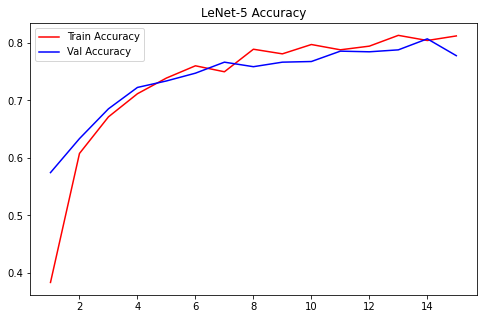

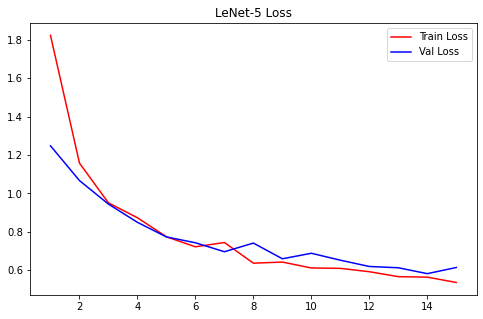

In [19]:
lenet_train_accuracy = history_lenet_model.history['accuracy']
lenet_val_acc = history_lenet_model.history['val_accuracy']

epochs = range(1, len(lenet_train_accuracy)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, lenet_train_accuracy, 'r', label= 'Train Accuracy')
plt.plot(epochs, lenet_val_acc, 'b', label= 'Val Accuracy')
plt.title("LeNet-5 Accuracy")
plt.legend()
plt.show()

lenet_train_loss = history_lenet_model.history['loss']
lenet_val_loss = history_lenet_model.history['val_loss']

plt.figure(figsize=(8,5))
plt.plot(epochs, lenet_train_loss, 'r', label= 'Train Loss')
plt.plot(epochs, lenet_val_loss, 'b', label= 'Val Loss')
plt.title("LeNet-5 Loss")
plt.legend()
plt.show()
